# Will the Ad be clicked?

## Installing libraries, dependencies, and data

In [42]:
# Import the required libraries and dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [43]:
# Read csv file as DataFrame, with the first column as row index
df = pd.read_csv("Dataset_Ads.csv")

# Preview the dataset
df.tail()

,Age,Gender,Income,Location,Ad Type,Ad Topic,Ad Placement,Clicks,Click Time,Conversion Rate,CTR
9995,7,Male,69925.29,Rural,Text,Fashion,Social Media,5,2023-05-31 20:45:56.927349,0.2460,0.1045
9996,35,Male,42182.75,Urban,Native,Technology,Website,9,2023-09-01 20:45:56.927349,0.2664,0.0407
9997,42,Male,55084.12,Suburban,Text,Finance,Search Engine,3,2023-11-15 20:45:56.927349,0.2354,0.0390
9998,34,Male,39382.80,Rural,Native,Technology,Social Media,4,2023-05-23 20:45:56.927349,0.1725,0.0455
9999,54,Female,66441.59,Suburban,Banner,Technology,Search Engine,2,2023-11-21 20:45:56.927349,0.0307,0.0323


## Data Cleanup and Preparation

In [44]:
# Checking the data types
df.dtypes

Age                  int64
Gender              object
Income             float64
Location            object
Ad Type             object
Ad Topic            object
Ad Placement        object
Clicks               int64
Click Time          object
Conversion Rate    float64
CTR                float64
dtype: object

In [45]:
# Checking for null values
df.isna().sum() / len(df)

Age                0.0
Gender             0.0
Income             0.0
Location           0.0
Ad Type            0.0
Ad Topic           0.0
Ad Placement       0.0
Clicks             0.0
Click Time         0.0
Conversion Rate    0.0
CTR                0.0
dtype: float64

In [46]:
# Remove ages that are below 18; This is under the assumption that users below 18 are not going to be converted into sales.
# Asked XPert Learning Assistant for code
df = df[df["Age"] >= 18]
df.tail()

,Age,Gender,Income,Location,Ad Type,Ad Topic,Ad Placement,Clicks,Click Time,Conversion Rate,CTR
9994,49,Female,72810.17,Rural,Banner,Technology,Website,9,2023-07-24 20:45:56.927349,0.0679,0.0443
9996,35,Male,42182.75,Urban,Native,Technology,Website,9,2023-09-01 20:45:56.927349,0.2664,0.0407
9997,42,Male,55084.12,Suburban,Text,Finance,Search Engine,3,2023-11-15 20:45:56.927349,0.2354,0.0390
9998,34,Male,39382.80,Rural,Native,Technology,Social Media,4,2023-05-23 20:45:56.927349,0.1725,0.0455
9999,54,Female,66441.59,Suburban,Banner,Technology,Search Engine,2,2023-11-21 20:45:56.927349,0.0307,0.0323


In [47]:
# Convert Click Time into Datetime
df["Click Time"] = pd.to_datetime(df["Click Time"], errors="coerce")
df.dtypes

Age                         int64
Gender                     object
Income                    float64
Location                   object
Ad Type                    object
Ad Topic                   object
Ad Placement               object
Clicks                      int64
Click Time         datetime64[ns]
Conversion Rate           float64
CTR                       float64
dtype: object

In [48]:
# Creating a DataFrame for the X value
X = df.drop(columns=["Clicks", "Click Time", "Conversion Rate","CTR"])
X

,Age,Gender,Income,Location,Ad Type,Ad Topic,Ad Placement
0,61,Male,35717.43,Urban,Banner,Travel,Social Media
1,41,Male,47453.25,Rural,Video,Travel,Search Engine
2,49,Female,68126.35,Rural,Text,Food,Social Media
3,68,Female,64585.73,Suburban,Text,Health,Website
4,63,Male,21109.40,Urban,Native,Fashion,Search Engine
...,...,...,...,...,...,...,...
9994,49,Female,72810.17,Rural,Banner,Technology,Website
9996,35,Male,42182.75,Urban,Native,Technology,Website
9997,42,Male,55084.12,Suburban,Text,Finance,Search Engine
9998,34,Male,39382.80,Rural,Native,Technology,Social Media


In [49]:
# Creating DataFrames for the y values
y_clicks = df["Clicks"]
y_ctr = df["CTR"]
y_clicks

0       3
1       5
2       4
3       6
4       5
       ..
9994    9
9996    9
9997    3
9998    4
9999    2
Name: Clicks, Length: 8694, dtype: int64

In [50]:
y_ctr

0       0.0737
1       0.0592
2       0.0563
3       0.0232
4       0.0539
         ...  
9994    0.0443
9996    0.0407
9997    0.0390
9998    0.0455
9999    0.0323
Name: CTR, Length: 8694, dtype: float64

In [51]:
# Creating a OneHotEncoder column function
def oheEncodeColumn(X_column):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    encoded_column = ohe.fit(X_train[X_column].values.reshape(-1, 1))
    return encoded_column

In [52]:
# This is a column that might contain variables with a specific order
X["Location"].value_counts()

Location
Rural       2960
Suburban    2877
Urban       2857
Name: count, dtype: int64

In [53]:
# Creating an OrdinalEncoder column function
def ordEncodeColumn(X_column):
    ord = OrdinalEncoder(categories=[["Rural", "Suburban", "Urban"]], encoded_missing_value=-1, handle_unknown="use_encoded_value", unknown_value=-1)
    encoded_column = ord.fit(X_train[X_column].values.reshape(-1, 1))
    return encoded_column

In [54]:
# Creating an encode function
def X_preprocess(X_data):
    # Creating an encoder for each X column
    # and Transforming them into numpy arrays

    # Gender column
    gender_ohe = oheEncodeColumn("Gender")
    gender_encoded = gender_ohe.transform(X_data["Gender"].values.reshape(-1,1))
    # Location column
    location_ord = ordEncodeColumn("Location")
    location_encoded = location_ord.transform(X_data["Location"].values.reshape(-1,1))
    # Ad Type column
    type_ohe = oheEncodeColumn("Ad Type")
    type_encoded = type_ohe.transform(X_data["Ad Type"].values.reshape(-1,1))
    # Ad Topic column
    topic_ohe = oheEncodeColumn("Ad Topic")
    topic_encoded = topic_ohe.transform(X_data["Ad Topic"].values.reshape(-1,1))
    # Ad Placement column
    placement_ohe = oheEncodeColumn("Ad Placement")
    placement_encoded = placement_ohe.transform(X_data["Ad Placement"].values.reshape(-1,1))

    # Turning each numpy array into a DataFrame
    gender_df = pd.DataFrame(gender_encoded, columns=gender_ohe.get_feature_names_out())
    type_df = pd.DataFrame(type_encoded, columns=type_ohe.get_feature_names_out())
    topic_df = pd.DataFrame(topic_encoded, columns=topic_ohe.get_feature_names_out())
    placement_df = pd.DataFrame(placement_encoded, columns=placement_ohe.get_feature_names_out())

    # Creating an encoded DataFrame
    out_df = pd.concat([gender_df, type_df, topic_df, placement_df], axis=1)
    out_df["Location"] = location_encoded
    # Return the DataFrame
    return out_df


In [55]:
# Sample train_test_spilt; Will delete later

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_ctr, random_state=42)
X_train.describe()

,Age,Income
count,6520.000000,6520.000000
mean,37.781288,50027.491334
std,12.131749,20048.237170
min,18.000000,-38932.640000
25%,28.000000,36512.977500
50%,37.000000,50029.210000
75%,46.000000,63241.760000
max,92.000000,126635.800000


## Question 1: What factors make someone more likely to click on an ad?
Summary

## Question 2: What Regression Model is best at predicting the data?
Summary

## Question 3: Can a Classification model predict if someone clicks on an ad?
Summary

In [56]:
df["Clicks"].value_counts()

Clicks
4     1528
5     1512
6     1266
3     1202
7      884
2      721
8      597
9      344
1      278
10     167
0       72
11      72
12      34
13       8
14       6
15       2
17       1
Name: count, dtype: int64

In [57]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_clicks, random_state=42)
X_train.describe()

,Age,Income
count,6520.000000,6520.000000
mean,37.781288,50027.491334
std,12.131749,20048.237170
min,18.000000,-38932.640000
25%,28.000000,36512.977500
50%,37.000000,50029.210000
75%,46.000000,63241.760000
max,92.000000,126635.800000


In [58]:
# Encode the X data with the X_preprocess function
X_train_encoded = X_preprocess(X_train)
X_test_encoded = X_preprocess(X_test)
X_train_encoded

,x0_Female,x0_Male,x0_Other,x0_Banner,x0_Native,x0_Text,x0_Video,x0_Fashion,x0_Finance,x0_Food,x0_Health,x0_Technology,x0_Travel,x0_Search Engine,x0_Social Media,x0_Website,Location
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6515,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6516,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
6517,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6518,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [59]:
from sklearn.preprocessing import StandardScaler
# Scale the X data by using StandardScaler()
scaler = StandardScaler().fit(X_train_encoded)
X_train_scaled = scaler.transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X_train_scaled

array([[-0.80635919, -1.00184219,  2.91860381, ..., -0.70751352,
        -0.70483051,  0.00320507],
       [-0.80635919,  0.9981612 , -0.34262958, ...,  1.41340056,
        -0.70483051,  1.23244208],
       [-0.80635919, -1.00184219,  2.91860381, ..., -0.70751352,
         1.41878082,  0.00320507],
       ...,
       [-0.80635919,  0.9981612 , -0.34262958, ..., -0.70751352,
         1.41878082, -1.22603195],
       [ 1.24014213, -1.00184219, -0.34262958, ..., -0.70751352,
         1.41878082, -1.22603195],
       [-0.80635919,  0.9981612 , -0.34262958, ..., -0.70751352,
         1.41878082, -1.22603195]])

In [60]:
# Encoding the clicks column using a custom function
def encode_clicks(clicks):
    if clicks > 0:
        return "Yes"
    else:
        return "No"
# Applying the function to y_train and y_test
y_train_encoded = y_train.apply(encode_clicks)
y_test_encoded = y_test.apply(encode_clicks)
y_train_encoded.value_counts()

Clicks
Yes    6460
No       60
Name: count, dtype: int64

In [61]:
# Import the RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# Instantiate a RandomForestClassifier instance
model = RandomForestClassifier()

# Fit the traning data to the model
model.fit(X_train_scaled, y_train_encoded)

RandomForestClassifier()

In [62]:
# Predict labels for original scaled testing features
y_pred = model.predict(X_test_scaled)

In [63]:
# Create a loop to vary the max_depth parameter
# Make sure to record the train and test scores 
# for each pass.

# Depths should span from 1 up to 15 in steps of 1
depths = range(1, 15)

# The scores dataframe will hold depths and scores
# to make plotting easy
scores = {"train":[], "test":[], "depth":[]}

# Loop through each depth
for depth in depths:
    clf = RandomForestClassifier(max_depth=depth)
    clf.fit(X_train_scaled, y_train_encoded)

    train_score = clf.score(X_train_scaled, y_train_encoded)
    test_score = clf.score(X_test_scaled, y_test_encoded)

    scores["depth"].append(depth)
    scores["train"].append(train_score)
    scores["test"].append(test_score)

# Create a dataframe from the scores dictionary and
# set the index to depth
scores_df = pd.DataFrame(scores).set_index("depth")
scores_df.head()

,train,test
depth,,
1,0.990798,0.99448
2,0.990798,0.99448
3,0.990798,0.99448
4,0.990798,0.99448
5,0.990798,0.99448


<Axes: xlabel='depth'>

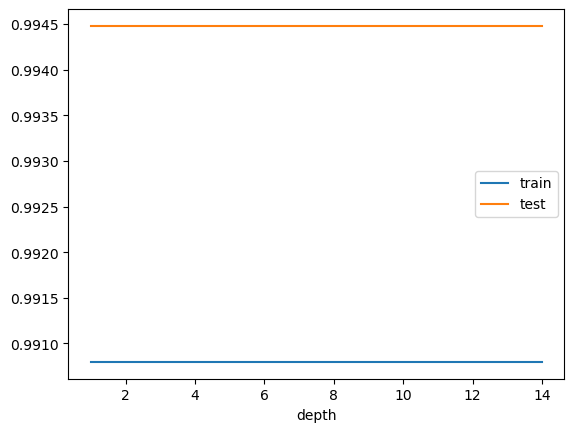

In [64]:
# Plot the scores dataframe with the plot method
scores_df.plot()

In [65]:
# Import RandomOverSampler from imblearn
from imblearn.over_sampling import RandomOverSampler

# Instantiate a RandomOversampler instance
ros = RandomOverSampler(random_state=1)

# Fit the training data to the `RandomOverSampler` model
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train_encoded)

# Count distinct values
y_resampled.value_counts()

Clicks
Yes    6460
No     6460
Name: count, dtype: int64

In [66]:
# Instantiate a new RandomForestClassier model
model_oversampled = RandomForestClassifier()

# Fit the oversampled data the new model
model_oversampled.fit(X_resampled, y_resampled)

RandomForestClassifier()

In [67]:
# Predict labels for oversampled testing features
y_pred_oversampled = model_oversampled.predict(X_test_scaled)

In [68]:
from sklearn.metrics import classification_report

# Print classification reports
print(f"Classification Report - Original Data")
print(classification_report(y_test_encoded, y_pred))
print("---------")
print(f"Classification Report - Oversampled Data")
print(classification_report(y_test_encoded, y_pred_oversampled))

Classification Report - Original Data
              precision    recall  f1-score   support

          No       0.00      0.00      0.00        12
         Yes       0.99      1.00      1.00      2162

    accuracy                           0.99      2174
   macro avg       0.50      0.50      0.50      2174
weighted avg       0.99      0.99      0.99      2174

---------
Classification Report - Oversampled Data
              precision    recall  f1-score   support

          No       0.00      0.00      0.00        12
         Yes       0.99      0.91      0.95      2162

    accuracy                           0.90      2174
   macro avg       0.50      0.45      0.47      2174
weighted avg       0.99      0.90      0.94      2174



In [69]:
# Import RandomUnderSampler from imblearn
from imblearn.under_sampling import RandomUnderSampler

# Instantiate a RandomUnderSampler instance
rus = RandomUnderSampler(random_state=1)
# Fit the training data to the random undersampler model
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train_encoded)
# Count distinct values for the resampled target data
y_resampled.value_counts()

Clicks
No     60
Yes    60
Name: count, dtype: int64

In [70]:
from sklearn.linear_model import LogisticRegression
# Instantiate a new RandomForestClassier model
model_undersampled = LogisticRegression()

# Fit the undersampled data the new model
model_undersampled.fit(X_resampled, y_resampled)

LogisticRegression()

In [71]:
# Predict labels for oversampled testing features
y_pred_undersampled = model_undersampled.predict(X_test_scaled)

In [72]:
# Print classification reports
print(f"Classification Report - Original Data")
print(classification_report(y_test_encoded, y_pred))
print("---------")
print(f"Classification Report - Undersampled Data")
print(classification_report(y_test_encoded, y_pred_undersampled))

Classification Report - Original Data
              precision    recall  f1-score   support

          No       0.00      0.00      0.00        12
         Yes       0.99      1.00      1.00      2162

    accuracy                           0.99      2174
   macro avg       0.50      0.50      0.50      2174
weighted avg       0.99      0.99      0.99      2174

---------
Classification Report - Undersampled Data
              precision    recall  f1-score   support

          No       0.01      0.58      0.01        12
         Yes       1.00      0.46      0.63      2162

    accuracy                           0.47      2174
   macro avg       0.50      0.52      0.32      2174
weighted avg       0.99      0.47      0.63      2174



## Question 4: What is the most desirable ad?
Summary